In [4]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

data = pd.read_csv('/kaggle/input/digit-recognizer/train.csv')

In [5]:
data = np.array(data)
m, n = data.shape
np.random.shuffle(data)

data_dev = data[0:1000].T
Y_dev = data_dev[0]
X_dev = data_dev[1:n]
X_dev = X_dev / 255.

data_train = data[1000:m].T
Y_train = data_train[0]
X_train = data_train[1:n]
X_train = X_train / 255.
_,m_train = X_train.shape

In [6]:
def init_params():
    W1 = np.random.rand(10, 784) - 0.5
    b1 = np.random.rand(10, 1) - 0.5
    W2 = np.random.rand(10, 10) - 0.5
    b2 = np.random.rand(10, 1) - 0.5
    return W1, b1, W2, b2

def ReLU(Z):
    return np.maximum(Z, 0)

def softmax(Z):
    A = np.exp(Z) / sum(np.exp(Z))
    return A
    
def forward_prop(W1, b1, W2, b2, X):
    Z1 = W1.dot(X) + b1
    A1 = ReLU(Z1)
    Z2 = W2.dot(A1) + b2
    A2 = softmax(Z2)
    return Z1, A1, Z2, A2

def ReLU_deriv(Z):
    return Z > 0

def one_hot(Y):
    one_hot_Y = np.zeros((Y.size, Y.max() + 1))
    one_hot_Y[np.arange(Y.size), Y] = 1
    one_hot_Y = one_hot_Y.T
    return one_hot_Y

def backward_prop(Z1, A1, Z2, A2, W1, W2, X, Y):
    one_hot_Y = one_hot(Y)
    dZ2 = A2 - one_hot_Y
    dW2 = 1 / m * dZ2.dot(A1.T)
    db2 = 1 / m * np.sum(dZ2)
    dZ1 = W2.T.dot(dZ2) * ReLU_deriv(Z1)
    dW1 = 1 / m * dZ1.dot(X.T)
    db1 = 1 / m * np.sum(dZ1)
    return dW1, db1, dW2, db2

def update_params(W1, b1, W2, b2, dW1, db1, dW2, db2, alpha, beta1, beta2, epsilon):
    v_dW1 = np.zeros_like(dW1)
    v_db1 = np.zeros_like(db1)
    v_dW2 = np.zeros_like(dW2)
    v_db2 = np.zeros_like(db2)
    s_dW1 = np.zeros_like(dW1)
    s_db1 = np.zeros_like(db1)
    s_dW2 = np.zeros_like(dW2)
    s_db2 = np.zeros_like(db2)
    
    v_dW1 = beta1 * v_dW1 + (1 - beta1) * dW1
    v_db1 = beta1 * v_db1 + (1 - beta1) * db1
    v_dW2 = beta1 * v_dW2 + (1 - beta1) * dW2
    v_db2 = beta1 * v_db2 + (1 - beta1) * db2
    
    s_dW1 = beta2 * s_dW1 + (1 - beta2) * dW1**2
    s_db1 = beta2 * s_db1 + (1 - beta2) * db1**2
    s_dW2 = beta2 * s_dW2 + (1 - beta2) * dW2**2
    s_db2 = beta2 * s_db2 + (1 - beta2) * db2**2
    
    v_dW1_corrected = v_dW1 / (1 - beta1)
    v_db1_corrected = v_db1 / (1 - beta1)
    v_dW2_corrected = v_dW2 / (1 - beta1)
    v_db2_corrected = v_db2 / (1 - beta1)
    
    s_dW1_corrected = s_dW1 / (1 - beta2)
    s_db1_corrected = s_db1 / (1 - beta2)
    s_dW2_corrected = s_dW2 / (1 - beta2)
    s_db2_corrected = s_db2 / (1 - beta2)
    
    W1 -= alpha * v_dW1_corrected / (np.sqrt(s_dW1_corrected) + epsilon)
    b1 -= alpha * v_db1_corrected / (np.sqrt(s_db1_corrected) + epsilon)
    W2 -= alpha * v_dW2_corrected / (np.sqrt(s_dW2_corrected) + epsilon)
    b2 -= alpha * v_db2_corrected / (np.sqrt(s_db2_corrected) + epsilon)

    return W1, b1, W2, b2

In [7]:
def get_predictions(A2):
    return np.argmax(A2, 0)

def get_accuracy(predictions, Y):
    ##print(predictions, Y)
    return np.sum(predictions == Y) / Y.size

def make_predictions(X, W1, b1, W2, b2):
    _, _, _, A2 = forward_prop(W1, b1, W2, b2, X)
    predictions = get_predictions(A2)
    return predictions

def gradient_descent(X, Y, alpha, beta1, beta2, epsilon, iterations):
    W1, b1, W2, b2 = init_params()
    best_train_acc = 0
    best_dev_acc = 0
    for i in range(iterations + 1):
        Z1, A1, Z2, A2 = forward_prop(W1, b1, W2, b2, X)
        dW1, db1, dW2, db2 = backward_prop(Z1, A1, Z2, A2, W1, W2, X, Y)
        W1, b1, W2, b2 = update_params(W1, b1, W2, b2, dW1, db1, dW2, db2, alpha, beta1, beta2, epsilon)
        
        if i % 50 == 0:
            predictions = get_predictions(A2)
            dev_predictions = make_predictions(X_dev, W1, b1, W2, b2)
            train_acc = get_accuracy(predictions, Y)
            dev_acc = get_accuracy(dev_predictions, Y_dev)
            
            print("Iteration:", i)
            if train_acc < best_train_acc:
                print("Train accuracy: {} \033[31m-{:.5f}\033[0m".format(train_acc, best_train_acc - train_acc))
            elif train_acc > best_train_acc:
                print("Train accuracy: {} \033[32m+{:.5f}\033[0m".format(train_acc, train_acc - best_train_acc))
            else:
                print("Train accuracy:", train_acc)
            
            if dev_acc < best_dev_acc:
                print("Dev accuracy: {} \033[31m-{:.5f}\033[0m".format(dev_acc, best_dev_acc - dev_acc))
                print("OVERFITTING")
            elif dev_acc > best_dev_acc:
                print("Dev accuracy: {} \033[32m+{:.5f}\033[0m".format(dev_acc, dev_acc - best_dev_acc))
            else:
                print("Dev accuracy:", dev_acc)
            
            best_train_acc = max(best_train_acc, train_acc)
            best_dev_acc = max(best_dev_acc, dev_acc)
            print("\n")
            
    return W1, b1, W2, b2

In [8]:
W1, b1, W2, b2 = gradient_descent(X_train, Y_train, 0.0016, 0.8, 0.999, 1e-8, 1000)

Iteration: 0
Train accuracy: 0.1274390243902439 +0.12744
Dev accuracy: 0.134 +0.13400


Iteration: 50
Train accuracy: 0.6157073170731707 +0.48827
Dev accuracy: 0.599 +0.46500


Iteration: 100
Train accuracy: 0.8233170731707317 +0.20761
Dev accuracy: 0.798 +0.19900


Iteration: 150
Train accuracy: 0.8661463414634146 +0.04283
Dev accuracy: 0.84 +0.04200


Iteration: 200
Train accuracy: 0.8810975609756098 +0.01495
Dev accuracy: 0.853 +0.01300


Iteration: 250
Train accuracy: 0.8895365853658537 +0.00844
Dev accuracy: 0.861 +0.00800


Iteration: 300
Train accuracy: 0.8942682926829268 +0.00473
Dev accuracy: 0.862 +0.00100


Iteration: 350
Train accuracy: 0.8966585365853659 +0.00239
Dev accuracy: 0.868 +0.00600


Iteration: 400
Train accuracy: 0.8984390243902439 +0.00178
Dev accuracy: 0.869 +0.00100


Iteration: 450
Train accuracy: 0.9001219512195122 +0.00168
Dev accuracy: 0.869


Iteration: 500
Train accuracy: 0.9004146341463415 +0.00029
Dev accuracy: 0.87 +0.00100


Iteration: 550
Train acc

In [9]:
def test_prediction(index, W1, b1, W2, b2):
    current_image = X_train[:, index, None]
    prediction = make_predictions(X_train[:, index, None], W1, b1, W2, b2)
    label = Y_train[index]
    print("Prediction:", prediction)
    print("Lable:", label)
    
    current_image = current_image.reshape((28, 28)) * 255
    plt.gray()
    plt.imshow(current_image, interpolation='nearest')
    plt.show()

Prediction: [4]
Lable: 2


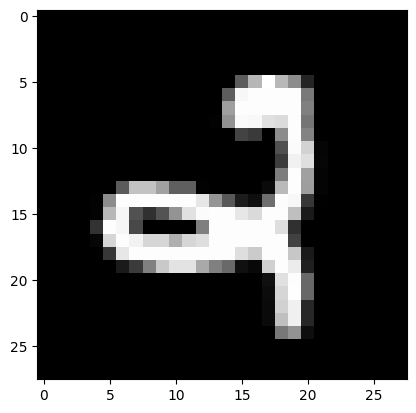

In [32]:
test_prediction(10, W1, b1, W2, b2)